# Завдання 2

## Опис завдання
Ви аналітик даних у відділі Operational Excellence великого онлайн-маркетплейсу товарів. У складі маркетплейсу 2
сервіси:
Платформа для роздрібного продажу.
Платформа для гуртового продажу.

Після численних скарг про низьку якість роботи відділу підтримки, вам доручено проаналізувати, як можна покращити
рівень обслуговування клієнтів.

Вхідні дані:
Кожен продукт має свою команду підтримки.
Кожне завдання старанний агент служби підтримки може виконувати до 5 хвилин з момента взяття в роботу.
З боку менеджменту є очікування, що в рамках кожного дня середній час від виникнення нового запиту користувача до відповіді має бути 15 хвилин. Також погано, якщо користувачі сервісу чекають на відповідь довше 45 хвилин.

Проаналізуйте дані про роботу служби підтримки за період та запропонуйте шляхи для підвищення якості
обслуговування.

Орієнтовний (але не вичерпний) приклад запитань для відповідей:  
- Наскільки служба підтримки відповідає очікуванням менеджменту? Як вона працює зараз?
- На яких агентів варто звернути увагу задля підвищення якості обслуговування?
- Чи варто збільшити команду підтримки і наскільки?
- Як варто змінити графік служби підтримки?
- Чи є вигода від об'єднання команд?

**Опис даних:**
Таблиця events - дані про кожний запит до модерації. Містять в собі інформацію про сам запит та модератора, який його виконував.
- `id_request` - унікальний ідентифікатор запиту;
- `moderator` - унікальний ідентифікатор агента підтримки;
- `team` - параметр команди (retail / wholesale);
- `request_time` - час отримання запиту;
- `start_time` - час початку обробки кейсу;
- `finish_time` - час кінця обробки кейсу.

## Імпорт бібліотек і підготовка даних


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_excel('events.xlsx')

In [3]:
df[:5]

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail


In [4]:
print(f'Розмір датафрейму {df.shape}')

Розмір датафрейму (35617, 6)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35617 entries, 0 to 35616
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   moderator     35617 non-null  int64         
 1   id_request    35617 non-null  int64         
 2   request_time  35617 non-null  datetime64[ns]
 3   start_time    35617 non-null  datetime64[ns]
 4   finish_time   35617 non-null  datetime64[ns]
 5   team          35617 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 1.6+ MB


#### Перевірка на наявність дублікатів рядків даних

In [6]:
df.duplicated().value_counts()

False    35617
Name: count, dtype: int64

**Висновок**:  
- дані завантажились правильно, колонки request_time, start_time і finish_time в форматі datetime
- пропущені значення відсутні
- дублікати відсутні

#### Додавання нових стовпців
- `request_date` - дата запиту;
- `request_hour` - година запиту;
- `request_dow` - день тижня, коли відбувся запит (0=Monday);
- `time_to_start` - час в хвилинах від запиту до момента взяття в роботу (час очікування);
- `time_to_finish` - час в хвилинах від запиту до кінця обробки запиту;
- `processing_time` - час в хвилинах обробки запиту.

In [7]:
df['request_date'] = df['request_time'].dt.date
df['request_hour'] = df['request_time'].dt.hour
df['request_dow'] = df['request_time'].dt.dayofweek

df['time_to_start'] = ((df['start_time'] - df['request_time']).dt.total_seconds() / 60).round(1)
df['time_to_finish'] = ((df['finish_time'] - df['request_time']).dt.total_seconds() / 60).round(1)
df['processing_time'] = ((df['finish_time'] - df['start_time']).dt.total_seconds() / 60).round(1)

In [8]:
df.head()

,moderator,id_request,request_time,start_time,finish_time,team,request_date,request_hour,request_dow,time_to_start,time_to_finish,processing_time
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail,2020-09-24,7,3,10619.2,10620.8,1.5
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail,2020-09-24,22,3,9529.4,9529.5,0.0
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale,2020-09-25,2,4,10599.0,10603.7,4.7
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail,2020-09-25,9,4,9939.0,9941.4,2.4
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail,2020-09-30,15,2,2381.4,2391.8,10.4


## Дослідницький аналіз даних


#### Кількість агентів в кожній команді

In [9]:
agents_per_team = df.groupby("team")['moderator'].nunique()
print("Кількість агентів у кожній команді:")
print(agents_per_team)

Кількість агентів у кожній команді:
team
retail       24
wholesale    25
Name: moderator, dtype: int64


#### Базова статистика для часу очікування і часу обробки запиту по кожній команді

In [10]:
metrics = ['time_to_start', 'processing_time']

# Отримуємо describe по кожній команді
team_describe = df.groupby('team')[metrics].describe().round(2)

# Витягуємо потрібні статистики
mean_df = team_describe.loc[:, (slice(None), 'mean')].droplevel(1, axis=1)
q25_df = team_describe.loc[:, (slice(None), '25%')].droplevel(1, axis=1)
q50_df = team_describe.loc[:, (slice(None), '50%')].droplevel(1, axis=1)
q75_df = team_describe.loc[:, (slice(None), '75%')].droplevel(1, axis=1)

team_describe

time_to_start                                                  \
                  count     mean      std  min    25%      50%      75%   
team                                                                      
retail          14025.0   607.79  5000.93  0.0   22.3    48.40    91.50   
wholesale       21592.0  3677.49  5018.51  0.0  899.3  3749.75  5183.82   

                    processing_time                                         
                max           count  mean   std  min  25%  50%   75%   max  
team                                                                        
retail      98641.9         14025.0  1.98  2.19  0.0  0.6  1.3  2.60  20.0  
wholesale  117132.1         21592.0  2.42  2.77  0.0  0.7  1.4  3.02  20.1

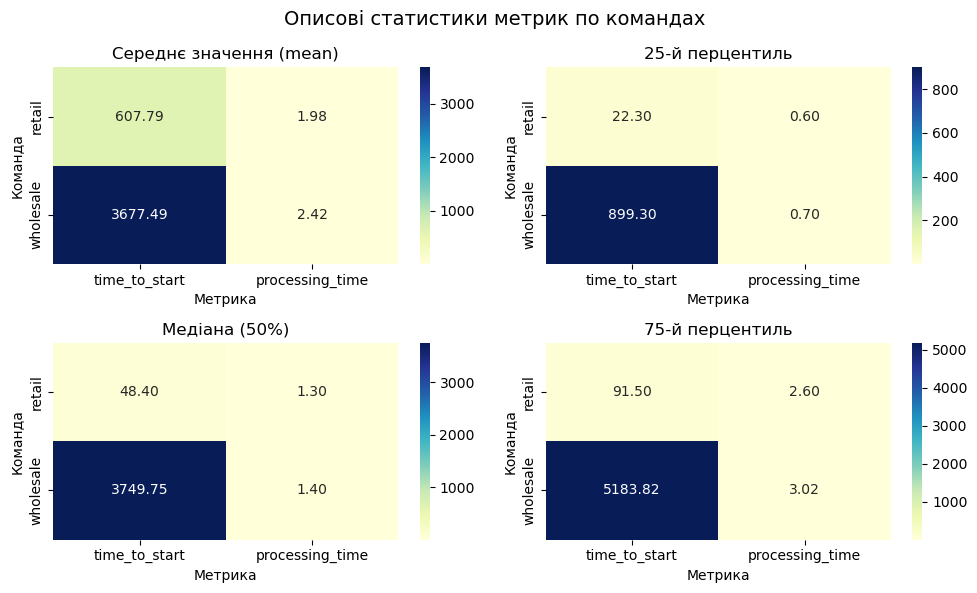

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

sns.heatmap(mean_df, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[0, 0])
axes[0, 0].set_title('Середнє значення (mean)')

sns.heatmap(q25_df, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[0, 1])
axes[0, 1].set_title('25-й перцентиль')

sns.heatmap(q50_df, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1, 0])
axes[1, 0].set_title('Медіана (50%)')

sns.heatmap(q75_df, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1, 1])
axes[1, 1].set_title('75-й перцентиль')

for ax in axes.flat:
    ax.set_xlabel('Метрика')
    ax.set_ylabel('Команда')

plt.suptitle('Описові статистики метрик по командах', fontsize=14)
plt.tight_layout()
plt.show()

#### Обчислимо середній час очікування в рамках кожного дня кожної команди окремо.

In [12]:
team_daily_avg = df.groupby(['request_date', 'team'])['time_to_start'].mean().reset_index()

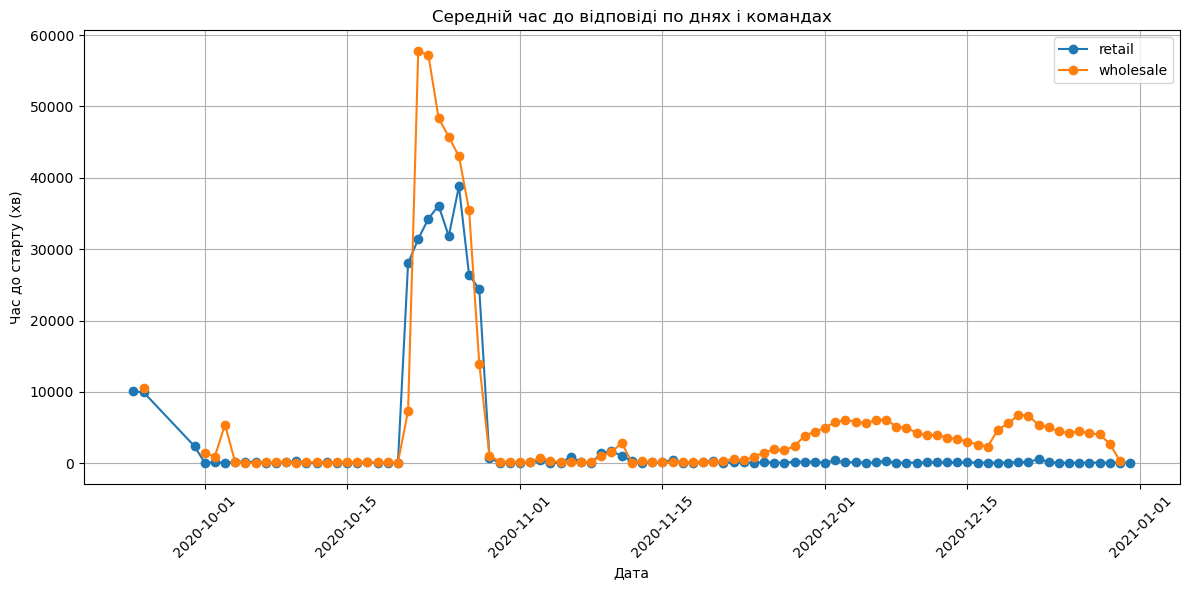

In [13]:
pivot_team_daily_avg = team_daily_avg.pivot(index='request_date', columns='team', values='time_to_start')

plt.figure(figsize=(12, 6))
for team in pivot_team_daily_avg.columns:
    plt.plot(pivot_team_daily_avg.index, pivot_team_daily_avg[team], marker='o', label=team)

plt.title('Середній час до відповіді по днях і командах')
plt.xlabel('Дата')
plt.ylabel('Час до старту (хв)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

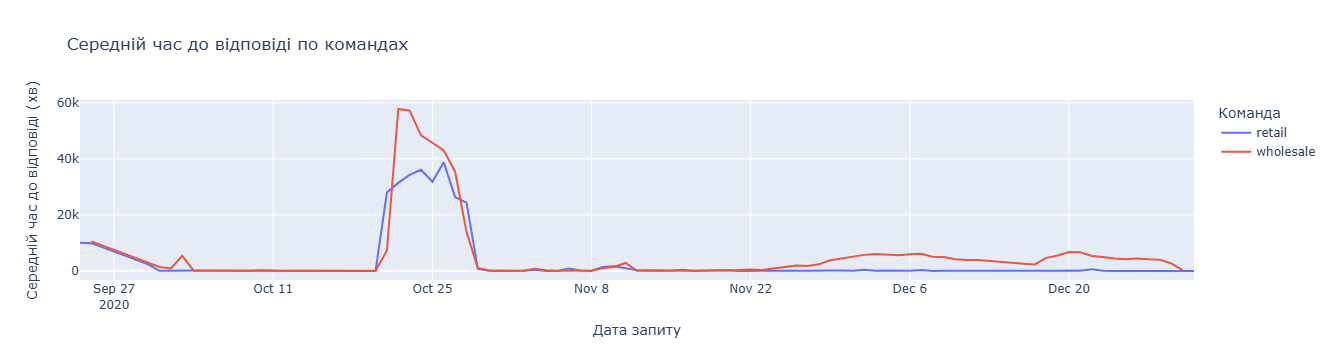

In [14]:
px.line(
    team_daily_avg,
    x='request_date',
    y='time_to_start',
    color='team',
    title='Середній час до відповіді по командах',
    labels={
        'request_date': 'Дата запиту',
        'time_to_start': 'Середній час до відповіді (хв)',
        'team': 'Команда'
    }
)

#### Обчислимо який відсоток середного часу очікування відповіді в рамках кожного дня <= 15 хв і який відсоток не перевищує 45 хв (що очікується з боку менеджменту) по командам

In [15]:
# Обчислення частки днів, де середній час ≤ 15 хв
sla_15 = team_daily_avg.groupby('team')['time_to_start'].apply(lambda x: (x <= 15).mean().round(3) * 100)

# Обчислення частки днів, де середній час ≤ 45 хв
sla_45 = team_daily_avg.groupby('team')['time_to_start'].apply(lambda x: (x <= 45).mean().round(3) * 100)

# Вивід результатів
print("Відсоток днів із середнім часом очікування ≤ 15 хв:")
print(sla_15)

print("\nВідсоток днів із середнім часом очікування ≤ 45 хв:")
print(sla_45)

Відсоток днів із середнім часом очікування ≤ 15 хв:
team
retail       0.0
wholesale    0.0
Name: time_to_start, dtype: float64

Відсоток днів із середнім часом очікування ≤ 45 хв:
team
retail       10.5
wholesale     1.1
Name: time_to_start, dtype: float64


#### Середній час обробки по днях по командам

In [16]:
team_daily_avg_processing = (
    df.groupby(['request_date', 'team'])['processing_time']
    .mean()
    .round(1)
    .reset_index()
)

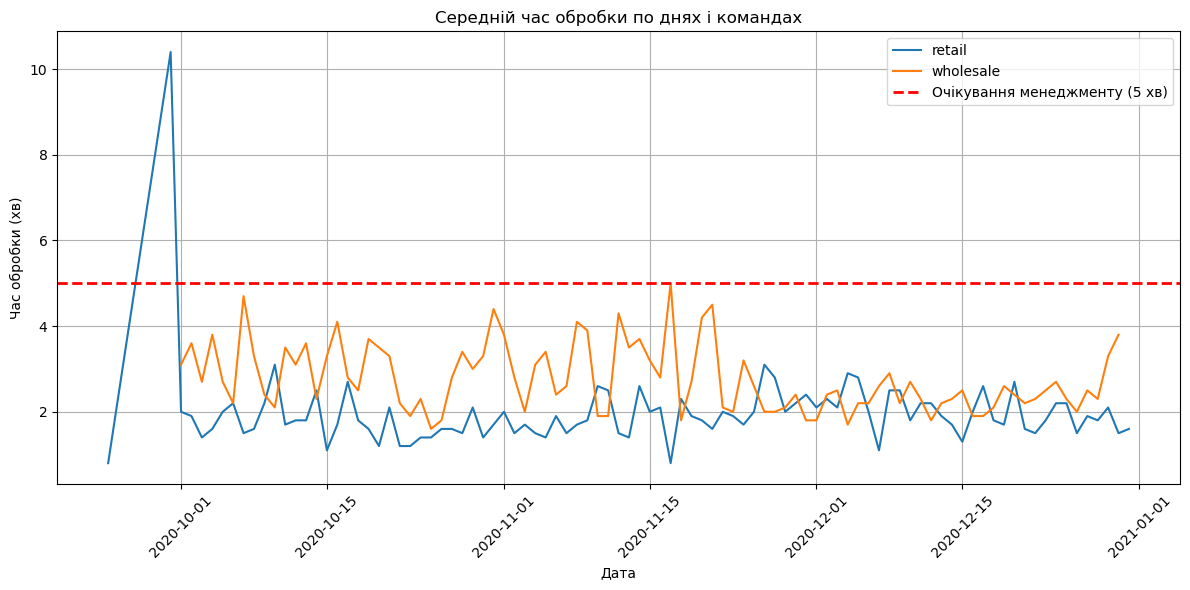

In [17]:
pivot_team_daily_avg_processing = team_daily_avg_processing.pivot(index='request_date', columns='team', values='processing_time')

plt.figure(figsize=(12, 6))
for team in pivot_team_daily_avg_processing.columns:
    plt.plot(pivot_team_daily_avg_processing.index, pivot_team_daily_avg_processing[team], label=team)

plt.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Очікування менеджменту (5 хв)')

plt.title('Середній час обробки по днях і командах')
plt.xlabel('Дата')
plt.ylabel('Час обробки (хв)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Висновки щодо порівняння команд по часу очікування:**
- середній час очікування на обробку запиту в команді retail - 608 хв, а в wholesale - 3677 хв. Отже wholesale в 6 разів повільніше працюють.
- у retail половина запитів стартує < 1 год , у wholesale - майже через 2.5 доби
- навіть найшвидші 25% у wholesale - дуже повільні (15 годин очікування)
- тільки 10.5% днів з середнім часом очікування 45 хв в команді retail, і 1% - для wholesale
- команда wholesale критично не відповідає очікуванням менеджменту (<= 45 хв). Retail теж перевищує, але значно ближче до норми.

**Висновки щодо порівняння команд по часу обробки запитів:**
- тут обидві команди відповідають очікуванням менеджменту (5 хв).

#### Кількість запитів по днях і годинах

In [18]:
hourly_counts = df.pivot_table(
    index='request_date',
    columns='request_hour',
    values='id_request',
    aggfunc='count',
    fill_value=0
)

#### Heatmap кількості запитів по днях і годинах

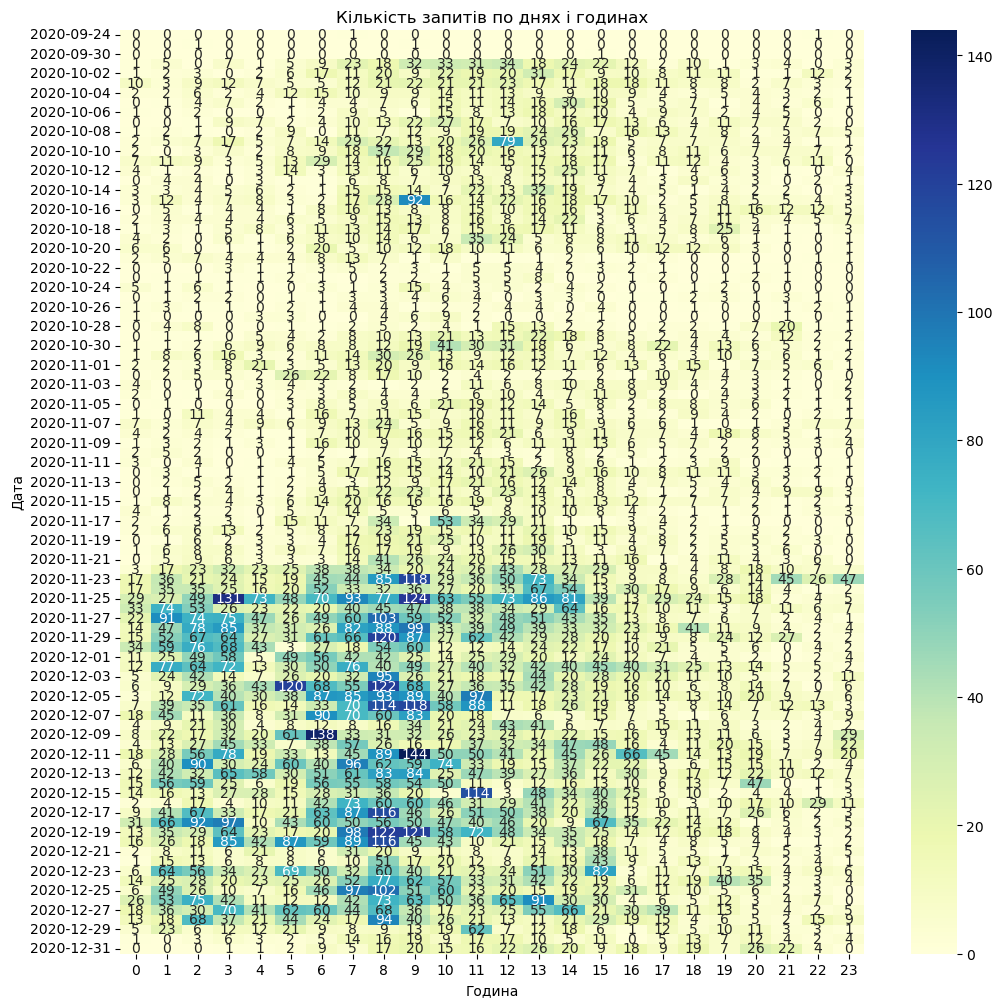

In [19]:
plt.figure(figsize=(12, 12))
sns.heatmap(hourly_counts, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Кількість запитів по днях і годинах')
plt.xlabel('Година')
plt.ylabel('Дата')
plt.show()

#### Виведемо модераторів, які з усього набору даних обробили <= 10 запитів

In [20]:
moderator_counts = df['moderator'].value_counts().reset_index()
moderator_counts.columns = ['moderator', 'request_count']

In [21]:
low_volume_mods = moderator_counts[moderator_counts['request_count'] <= 10]

In [22]:
# Витягуємо унікальні пари модератор–команда
moderator_teams = df[['moderator', 'team']].drop_duplicates()

# З'єднуємо з таблицею кількості
low_volume_mods = low_volume_mods.merge(moderator_teams, on='moderator', how='left')

In [23]:
print(low_volume_mods.sort_values(by='request_count'))

   moderator  request_count       team
3        129              1  wholesale
4        138              1     retail
5        110              1     retail
6        171              1  wholesale
1        126              2  wholesale
2        133              2     retail
0        134              8     retail


#### Середній час до відповіді по кожному агенту

In [24]:
avg_time_to_start = df.groupby("moderator")['time_to_start'].mean().sort_values()
print("Середній час до відповіді по агентам:")
print(avg_time_to_start)

Середній час до відповіді по агентам:
moderator
129       0.000000
138       0.100000
134       1.112500
171       2.800000
110       7.100000
114      73.075000
150     116.506250
167     268.814179
161     270.865193
178     387.208571
144     391.508197
128     395.327004
133     439.000000
135     440.737573
117     454.777378
163     473.661538
165     534.846991
143     535.606383
111     542.818981
152     586.185744
172     591.040169
173     591.598858
186     606.536438
176     611.764010
136     631.017135
148     647.571525
141     649.436325
121     690.440300
116     706.551724
164     728.006250
109     745.484281
185    1205.836000
156    1263.687701
175    2722.350000
103    3000.178142
153    3169.710143
146    3225.005611
122    3316.828683
149    3486.958855
125    3620.503490
102    3714.670780
123    3762.907782
170    3883.557948
188    4058.972931
187    4372.227410
112    4382.391147
180    4579.584136
181    4692.150215
126    5996.450000
Name: time_to_start, 

#### Поділ агентів на швидких і повільних по середнбому часу очікування початку обробки запиту

In [25]:
# Обчислення середнього time_to_start по модераторам
moderator_avg_start = df.groupby('moderator')['time_to_start'].mean().reset_index()

# Додавання команди
moderator_avg_start = moderator_avg_start.merge(df[['moderator', 'team']].drop_duplicates(), on='moderator', how='left')

# Перейменування
moderator_avg_start = moderator_avg_start.rename(columns={'time_to_start': 'avg_time_to_start'})

# Сортування
moderator_avg_start = moderator_avg_start.sort_values(by='avg_time_to_start', ascending=False).reset_index(drop=True)

# Таблиця: модератори з avg_time_to_start > 45 хв
slow_moderators = moderator_avg_start[moderator_avg_start['avg_time_to_start'] > 45]

# Таблиця: модератори з avg_time_to_start ≤ 45 хв
fast_moderators = moderator_avg_start[moderator_avg_start['avg_time_to_start'] <= 45]

# Вивід
print(" Модератори з середнім часом очікування > 45 хв:")
print(slow_moderators)

print("\n Модератори з середнім часом очікування ≤ 45 хв:")
print(fast_moderators)

 Модератори з середнім часом очікування > 45 хв:
    moderator  avg_time_to_start       team
0         126        5996.450000  wholesale
1         181        4692.150215  wholesale
2         180        4579.584136  wholesale
3         112        4382.391147  wholesale
4         187        4372.227410  wholesale
5         188        4058.972931  wholesale
6         170        3883.557948  wholesale
7         123        3762.907782  wholesale
8         102        3714.670780  wholesale
9         125        3620.503490  wholesale
10        149        3486.958855  wholesale
11        122        3316.828683  wholesale
12        146        3225.005611  wholesale
13        153        3169.710143  wholesale
14        103        3000.178142  wholesale
15        175        2722.350000  wholesale
16        156        1263.687701     retail
17        185        1205.836000  wholesale
18        109         745.484281     retail
19        164         728.006250     retail
20        116         706.5

#### Поділ агентів на шидких і повільних по середньому часу обробки запитів

In [26]:
# Обчислення середнього processing_time по модераторам
moderator_avg_processing = df.groupby('moderator')['processing_time'].mean().reset_index()

# Додавання команди
moderator_avg_processing = moderator_avg_processing.merge(df[['moderator', 'team']].drop_duplicates(), on='moderator', how='left')

# Перейменування
moderator_avg_processing = moderator_avg_processing.rename(columns={'processing_time': 'avg_processing_time'})

# Сортування
moderator_avg_processing = moderator_avg_processing.sort_values(by='avg_processing_time', ascending=False).reset_index(drop=True)

# Модератори з avg_processing_time > 5 хв
slow_processing_mods = moderator_avg_processing[moderator_avg_processing['avg_processing_time'] > 5]

# Модератори з avg_processing_time ≤ 5 хв
fast_processing_mods = moderator_avg_processing[moderator_avg_processing['avg_processing_time'] <= 5]

print("  Модератори з середнім часом обробки > 5 хв:")
print(slow_processing_mods)

print("\n Модератори з середнім часом обробки ≤ 5 хв:")
print(fast_processing_mods)

  Модератори з середнім часом обробки > 5 хв:
   moderator  avg_processing_time    team
0        133             10.70000  retail
1        150              5.10625  retail

 Модератори з середнім часом обробки ≤ 5 хв:
    moderator  avg_processing_time       team
2         149             4.350067  wholesale
3         167             4.318284     retail
4         175             3.756667  wholesale
5         163             3.436154  wholesale
6         161             3.093923  wholesale
7         187             3.075356  wholesale
8         185             3.060000  wholesale
9         123             3.056474  wholesale
10        122             3.049674  wholesale
11        144             3.027869  wholesale
12        146             2.993069  wholesale
13        141             2.911781     retail
14        129             2.900000  wholesale
15        153             2.876492  wholesale
16        181             2.795754  wholesale
17        143             2.698582  wholesale


#### Час обробки по модераторам з розподілом по командах

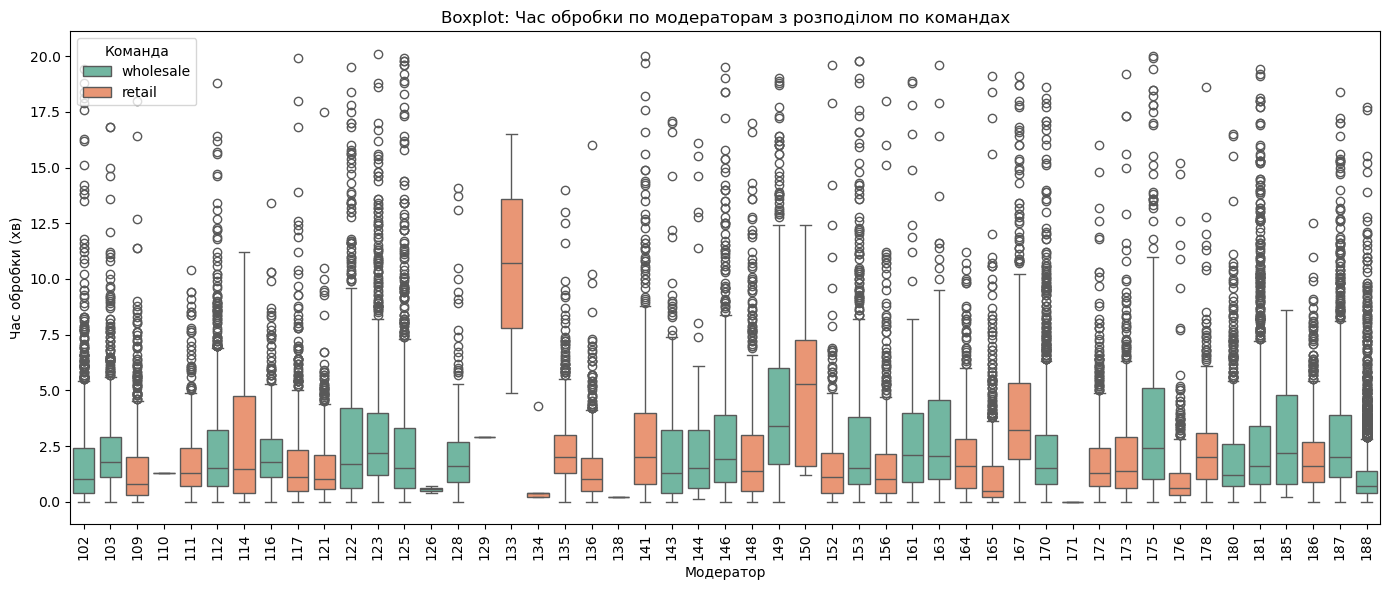

In [27]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="moderator", y="processing_time", hue="team", palette="Set2")
plt.title("Boxplot: Час обробки по модераторам з розподілом по командах")
plt.xlabel("Модератор")
plt.ylabel("Час обробки (хв)")
plt.xticks(rotation=90)
plt.legend(title="Команда")
plt.tight_layout()
plt.show()

#### Кількість кейсів на одного модератора поденно

In [28]:
df['date'] = df['request_time'].dt.date
cases_per_agent_daily = df.groupby(['date', 'moderator'])['id_request'].count()

print("Кількість кейсів на модератора поденно:")
print(cases_per_agent_daily)

Кількість кейсів на модератора поденно:
date        moderator
2020-09-24  165           1
            178           1
2020-09-25  178           1
            187           1
2020-09-30  178           1
                         ..
2020-12-31  121          66
            136          37
            164          13
            173           5
            176          60
Name: id_request, Length: 1633, dtype: int64


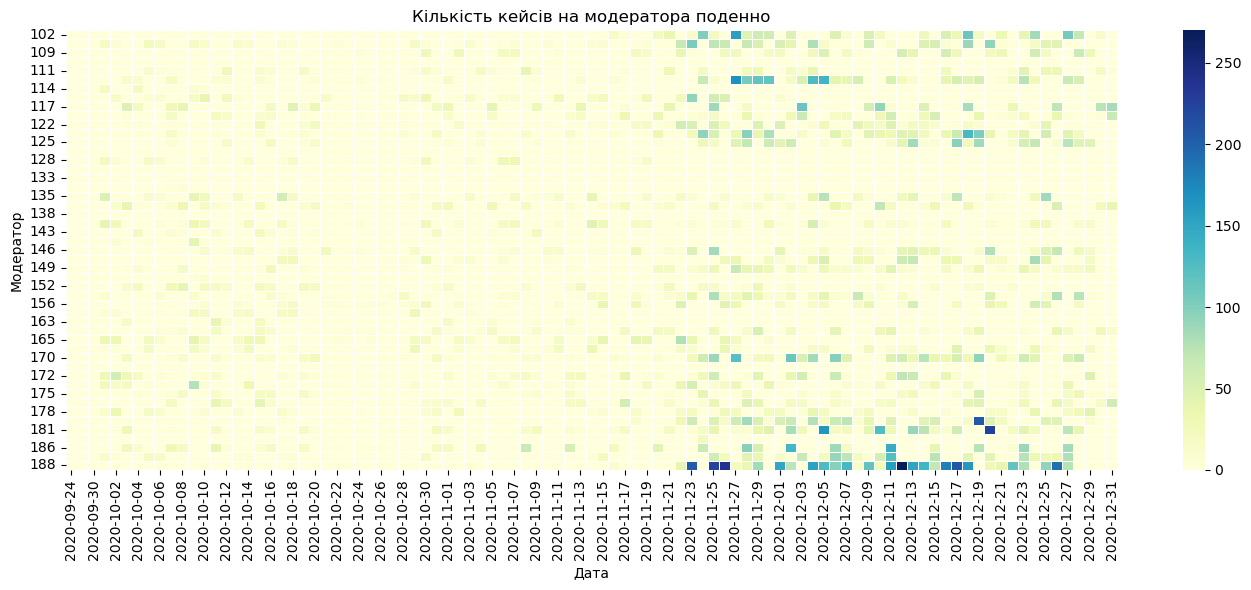

In [29]:
# Перетворення у зведену таблицю
pivot_cases = cases_per_agent_daily.unstack(fill_value=0)

# Побудова теплової карти
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_cases.T, cmap='YlGnBu', linewidths=0.5)
plt.title('Кількість кейсів на модератора поденно')
plt.xlabel('Дата')
plt.ylabel('Модератор')
plt.tight_layout()
plt.show()

#### Розподіл кількості кейсів на день по модераторам з розподілом по командах

In [30]:
# Додаємо колонку team до cases_df через злиття з оригінальним df
cases_df = cases_per_agent_daily.reset_index().rename(columns={'id_request': 'case_count'})
cases_df = cases_df.merge(df[['moderator', 'team']].drop_duplicates(), on='moderator', how='left')

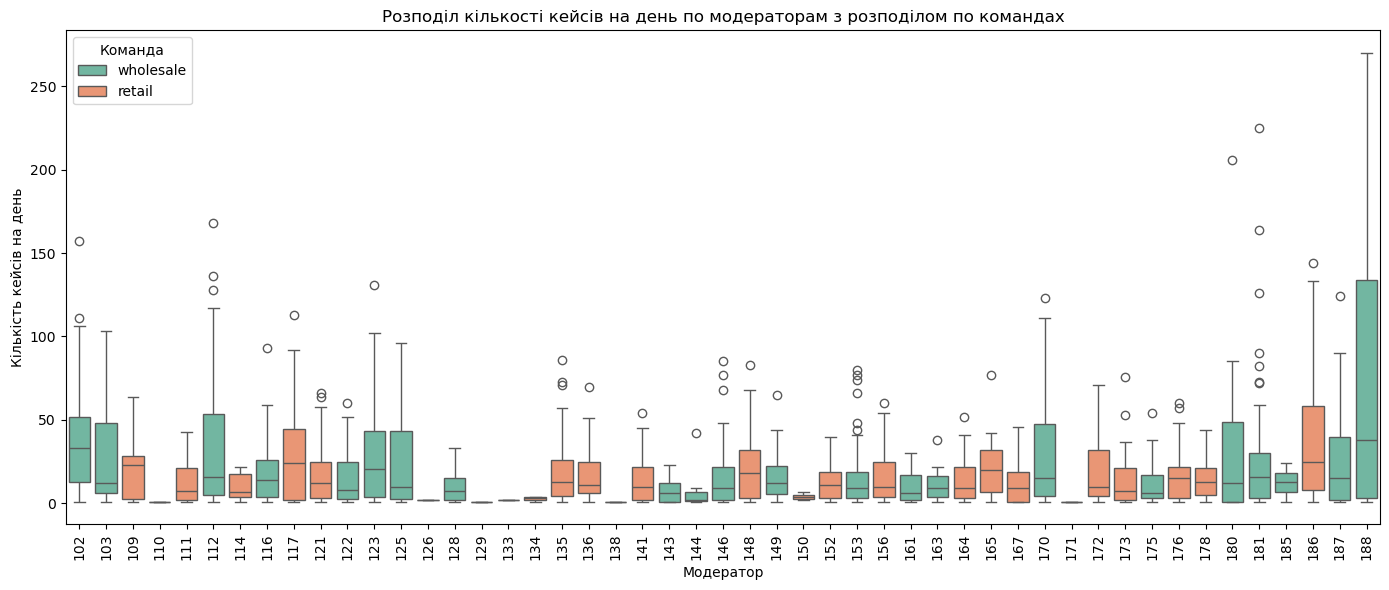

In [31]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=cases_df, x='moderator', y='case_count', hue='team', palette='Set2')
plt.title('Розподіл кількості кейсів на день по модераторам з розподілом по командах')
plt.xlabel('Модератор')
plt.ylabel('Кількість кейсів на день')
plt.xticks(rotation=90)
plt.legend(title='Команда')
plt.tight_layout()
plt.show()

#### Динаміка кейсів по топ-5 модераторам

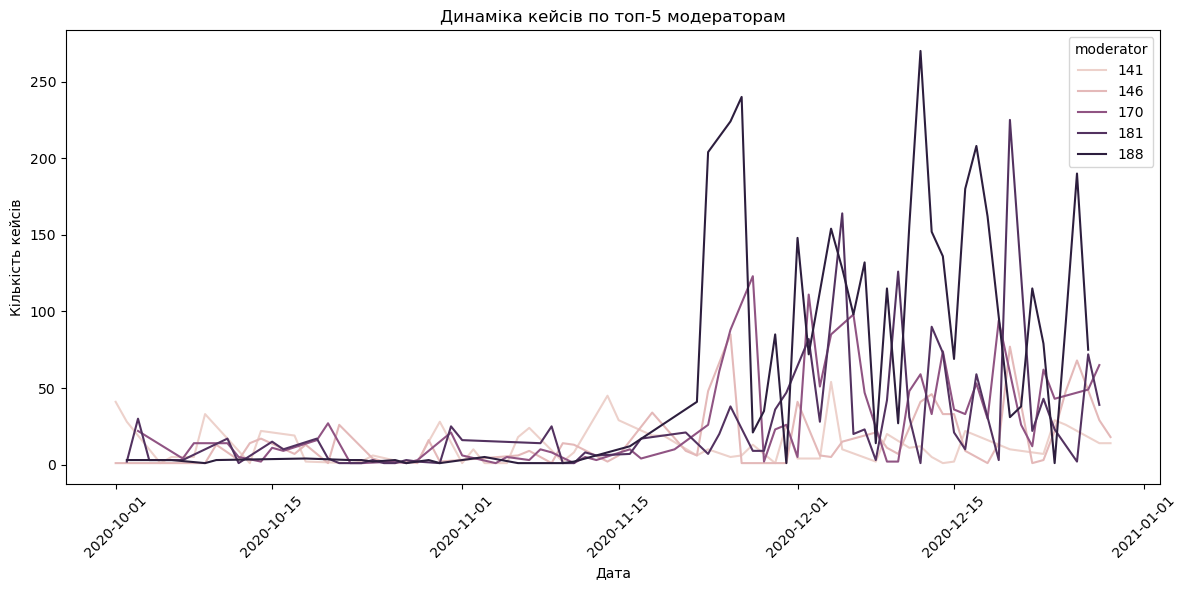

In [32]:
top_mods = cases_df['moderator'].value_counts().head(5).index
subset = cases_df[cases_df['moderator'].isin(top_mods)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset, x='date', y='case_count', hue='moderator')
plt.title('Динаміка кейсів по топ-5 модераторам')
plt.xlabel('Дата')
plt.ylabel('Кількість кейсів')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Висновки по агентам:**
- агенти 129, 138, 110, 171, 126, 133 за весь час обробили 1-2 запити. Можливо вони були новачками (або більше не працюють)
- агенти 133 та 150 мають середній час обробки > 5 хв
- агенти 110, 171, 134, 138, 129 мають час очікування <= 45 хв. Також показники агентів 129, 138 виглядають досить дивно
- майже всі агенти перевищують критичний час очікування 45 хв. 
- топ-5 агентів по кількості запитів на день: 188, 181, 170, 146, 141
- динаміка кейсів по топ-модераторам зростаюча

#### Кількість запитів по годинах для кожної команди

In [33]:
requests_hourly_team = df.groupby(['request_hour', 'team'])['id_request'].count().reset_index()
requests_hourly_team = requests_hourly_team.rename(columns={'id_request': 'request_count'})

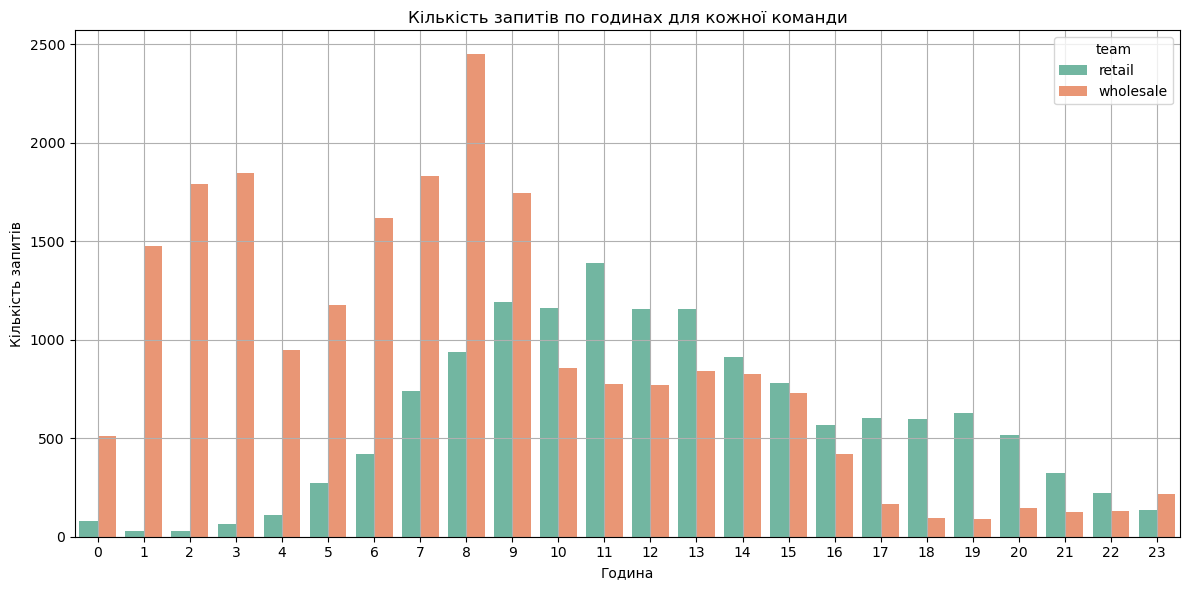

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(data=requests_hourly_team, x='request_hour', y='request_count', hue='team', palette='Set2')
plt.title('Кількість запитів по годинах для кожної команди')
plt.xlabel('Година')
plt.ylabel('Кількість запитів')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

**Висновки щодо графіку роботи служби підтримки:**
- Wholesale має чітко виражені піки по кількості запитів між 1:00 і 9:00, особливо о 8:00 - це період максимального навантаження
- Retail працює більш рівномірно, максимальні навантаження між 8:00 і 15:00

**Рекомендації як варто змінити графік роботи служби підтримки:**
- збільшити кількість агентів у командах в години з максимальними кількостями запитів
- можна зменшити кількість агентів або залишити чергових, особливо якщо запити стабільно низькі з 0:00 до 6:00 і  після 21:00 для retail; після 16:00 для wholesale

**Чи є вигода від об'єднання команд:**
- Потенційні переваги:
   - можна швидше реагувати на пікові навантаження, перерозподіляючи агентів
   - у вечірні години (ппісля 16:00) можна залишити менше людей, які обслуговують усі запити
- Потенційні ризики:
   - втрата спеціалізації: retail і wholesale можуть мати різні типи запитів
   - навчання та адаптація: агенти повинні вміти обробляти запити з обох напрямків
- щоб перевірити чи є вигода в об'єднанні команд, потрібно підійти аналітично: сформулювати гіпотези, обрати метрики, і порівняти сценарії.

Сформулюємо гіпотези:
- H₀ (нульова): Об'єднання команд не покращує ефективність.
- H₁ (альтернативна): Об'єднання команд дає вигоду - наприклад, зменшує час очікування, підвищує рівномірність навантаження або знижує кількість простояів.

А далі провести аналіз.

#### Обчислимо чи потрібно збільшити команди

In [37]:
# Кількість запитів по годинах і командах
requests_by_team = df.groupby(['team', 'request_hour'])['id_request'].count()

# Кількість унікальних агентів по годинах і командах
moderators_by_team = df.groupby(['team', 'request_hour'])['moderator'].nunique()

# Бажане максимальне навантаження на одного агента
desired_max_load = 15

# Обчислення потрібної кількості агентів
required_agents = (requests_by_team / desired_max_load).apply(np.ceil)

# Побудова таблиці
staffing_by_team = pd.DataFrame({
    'requests': requests_by_team,
    'actual_agents': moderators_by_team,
    'required_agents': required_agents
})

# Дефіцит = потрібні - фактичні
staffing_by_team['deficit'] = staffing_by_team['required_agents'] - staffing_by_team['actual_agents']

# Фільтрація годин з дефіцитом
deficit_by_team = staffing_by_team[staffing_by_team['deficit'] > 0]

# Вивід
print(" Години з дефіцитом агентів по командах:")
print(deficit_by_team)

 Години з дефіцитом агентів по командах:
                        requests  actual_agents  required_agents  deficit
team      request_hour                                                   
retail    5                  271             17             19.0      2.0
          6                  420             17             28.0     11.0
          7                  741             22             50.0     28.0
          8                  937             19             63.0     44.0
          9                 1194             19             80.0     61.0
          10                1159             22             78.0     56.0
          11                1391             21             93.0     72.0
          12                1154             19             77.0     58.0
          13                1154             19             77.0     58.0
          14                 913             19             61.0     42.0
          15                 781             12             53.0     41

**Висновки щодо розміру команди:**
- команди явно недоукомплектовані, про що свідчить величезний час очікувааня time_to_start
- протягом всієї доби не вистачає агентів (розрахунок виконано при бажаному навантаженні 15 запитів на 1 агента)
- кількість агентів у пікові години потрібно збільшити в 2-3 рази
- перерозподіляти навантаження між командами


**ЗАГАЛЬНІ ВИСНОВКИ:**
- служба підтримки не відповідає очікуванням менеджменту. Досить великий середній час до відповіді по кожній команді. Тільки 1% від запиту до відповіді не перевищує 45 хв. Варто збільшити кількість агентів або скоротити черги
- причиною поганого сервісу є не тривала обробка, а затримка між request_time і start_time. Можливі причини: запити накопичуються в черзі або start_time фіксується з затримкою.
- навантаження по кількості запитів по командам надходить нерівномірно. Потрібно перерозподіляти ресурси 
- найбільша кількість запитів надходить між 1:00 і 9:00 для Wholesale, і між 8:00 і 15:00 для Retail. Необхідно зміснити графік роботи агентів до цих годин.
- в період з 20.10.2020 до 30.10.2020 потрібно відслідкувати причини, чому середній час від запиту до відповіді зріс в декілька тисяч разів. Можливо недоступність або перевантаження команди, технічні проблеми або зміни в системі, зміна політики обробки запиті
- більшості агентам потрібне пройти навчання, або коучинг або зменшити навантаження
- команди недостатнього розміру, щоб обробляти таку кількість запитів
 
**Рекомендації:**
- перевірити, чи request_time і start_time записуються в однаковому часовому поясі й чи немає проблем з ETL/логікою
- провести аналіз черг
- впровадити систему раннього попередження про перевантаження
- провести аналіз типів запитів
- використати A/B тестування для змін у графіку
- розглянути часткове об’єднання команд
- впровадити прогнозування навантаження
- виконати розрахунок потрібного розміру команди
- провести аудит навичок агентів
- оцінити емоційне вигорання агентів